# Notebook for main overview figure (Fig.1)

Before you can run this notebook you should run our model or download the traces with the samples (see Readme). You can find the scripts to run model on `scripts/run_on_cluster` folder.


In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from tqdm.auto import tqdm
import os


sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:


""" General configs
"""
fig_path = "./figures"
xlim_ts = [datetime.datetime(2021,5,30),datetime.datetime(2021,7,23)] # Plotting range

ylims_fraction = { #ylims for fraction plots
    "Germany":[0.8,1.7],
    "Scotland":[0.8,2.3],
    "England":[0.9,1.4],
    "France":[0.65,1.35],
}
ylims_cases = {
    "Germany":[0,200],
    "Scotland":[0,1100],
    "England":[0,1100],
    "France":[0,500],
}
# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

Next we load all traces from the simulations. Check the path and simulation parameters if you can't load them here.

In [4]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

## Main figure (overview)

Create overview plot for all countries, you may need to change the data path to run it locally.

In [5]:
countries = ["England","Scotland","Germany","France","Spain","Slovakia","Portugal","Netherlands","Italy","Czechia","Belgium","Austria"]
traces, models, dls = [], [], []
for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"
        f"-len=normal"+                    
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/12 [00:00<?, ?it/s]

Use 1500 sample runs for England
Use 8000 sample runs for Scotland
Use 8000 sample runs for Germany
Use 4000 sample runs for France
Use 8000 sample runs for Spain
Use 8000 sample runs for Slovakia
Use 4000 sample runs for Portugal
Use 8000 sample runs for Netherlands
Use 8000 sample runs for Italy
Use 8000 sample runs for Czechia
Use 8000 sample runs for Belgium
Use 8000 sample runs for Austria


/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:786: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(
/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:797: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(


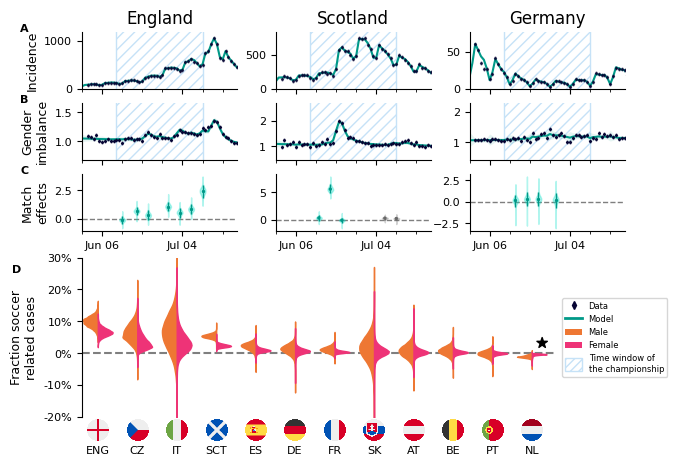

In [55]:
fig = plt.figure(figsize=(7, 5))
axes = covid19_soccer.plot.overview.multi_v2(
    traces=traces,
    models=models,
    dls=dls,
    xlim=xlim_ts,
    selected_index=[0,1,2],
    nColumns=3,
    fig=fig,
    ypos_flags=-20
)
axes[-1][0].set_ylim(-20,30)
axes[-1][0].set_ylabel("Fraction soccer\nrelated cases")
axes[-1][0].set_facecolor('none')

# Add label letters to figure
letters = np.array(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
text_kwargs = {
    "x":-0.40,
    "y":1.15,
    "fontsize":8,
    "fontweight":"bold",
    "verticalalignment":"top"
}
axes[0][0].text(
    s=letters[0],
    transform=axes[0][0].transAxes,
    **text_kwargs
)
axes[0][1].text(
    s=letters[1],
    transform=axes[0][1].transAxes,
    **text_kwargs
)
axes[0][2].text(
    s=letters[2],
    transform=axes[0][2].transAxes,
    **text_kwargs
)
axes[3][0].text(
    s=letters[3],
    transform=axes[0][2].transAxes,
    x=text_kwargs["x"]-0.05,
    y=-0.6,
    fontsize=8,
    fontweight="bold",
    verticalalignment="top"
)

# Add star to netherlands
axes[3][0].scatter(11.2,3,marker='$\star$',color="black",s=100)
axes[3][0].spines["bottom"].set_visible(False)
axes[3][0].set_xlim(-0.4,11.6)

fig.savefig(f"{fig_path}/overview_infections.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/overview_infections.png", **save_kwargs)

plt.show()
plt.close(fig=fig)

## Main figure with beta

In [5]:
countries = ["England","Scotland","Germany","France","Spain","Slovakia","Portugal","Netherlands","Italy","Czechia","Belgium","Austria"]
tune = 1000
draws = 2000
max_treedepth = 12
traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    try:
        fstr=(f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
            f"-beta=True"+
            f"-country={country}"+
            f"-offset_data=0"+
            f"-draw_delay=True"+
            f"-weighted_alpha_prior=0"+
            f"-prior_delay=-1"+
            f"-width_delay_prior=0.1"+
            f"-sigma_incubation=-1.0"+
            f"-median_width_delay=1.0"+
            f"-interval_cps=10.0"+
            f"-tune={1000}"+
            f"-draws={2000}"+
            f"-max_treedepth={max_treedepth}.pickled")
        model, trace = load(fstr)
    except:
        fstr=(f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
            f"-beta=True"+
            f"-country={country}"+
            f"-offset_data=0"+
            f"-draw_delay=True"+
            f"-weighted_alpha_prior=0"+
            f"-prior_delay=-1"+
            f"-width_delay_prior=0.1"+
            f"-sigma_incubation=-1.0"+
            f"-median_width_delay=1.0"+
            f"-interval_cps=10.0"+
            f"-tune={500}"+
            f"-draws={1000}"+
            f"-max_treedepth={max_treedepth}.pickled")
        model, trace = load(fstr)       
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/12 [00:00<?, ?it/s]

/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:687: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=2.5,),)
/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:691: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=2.5,),)


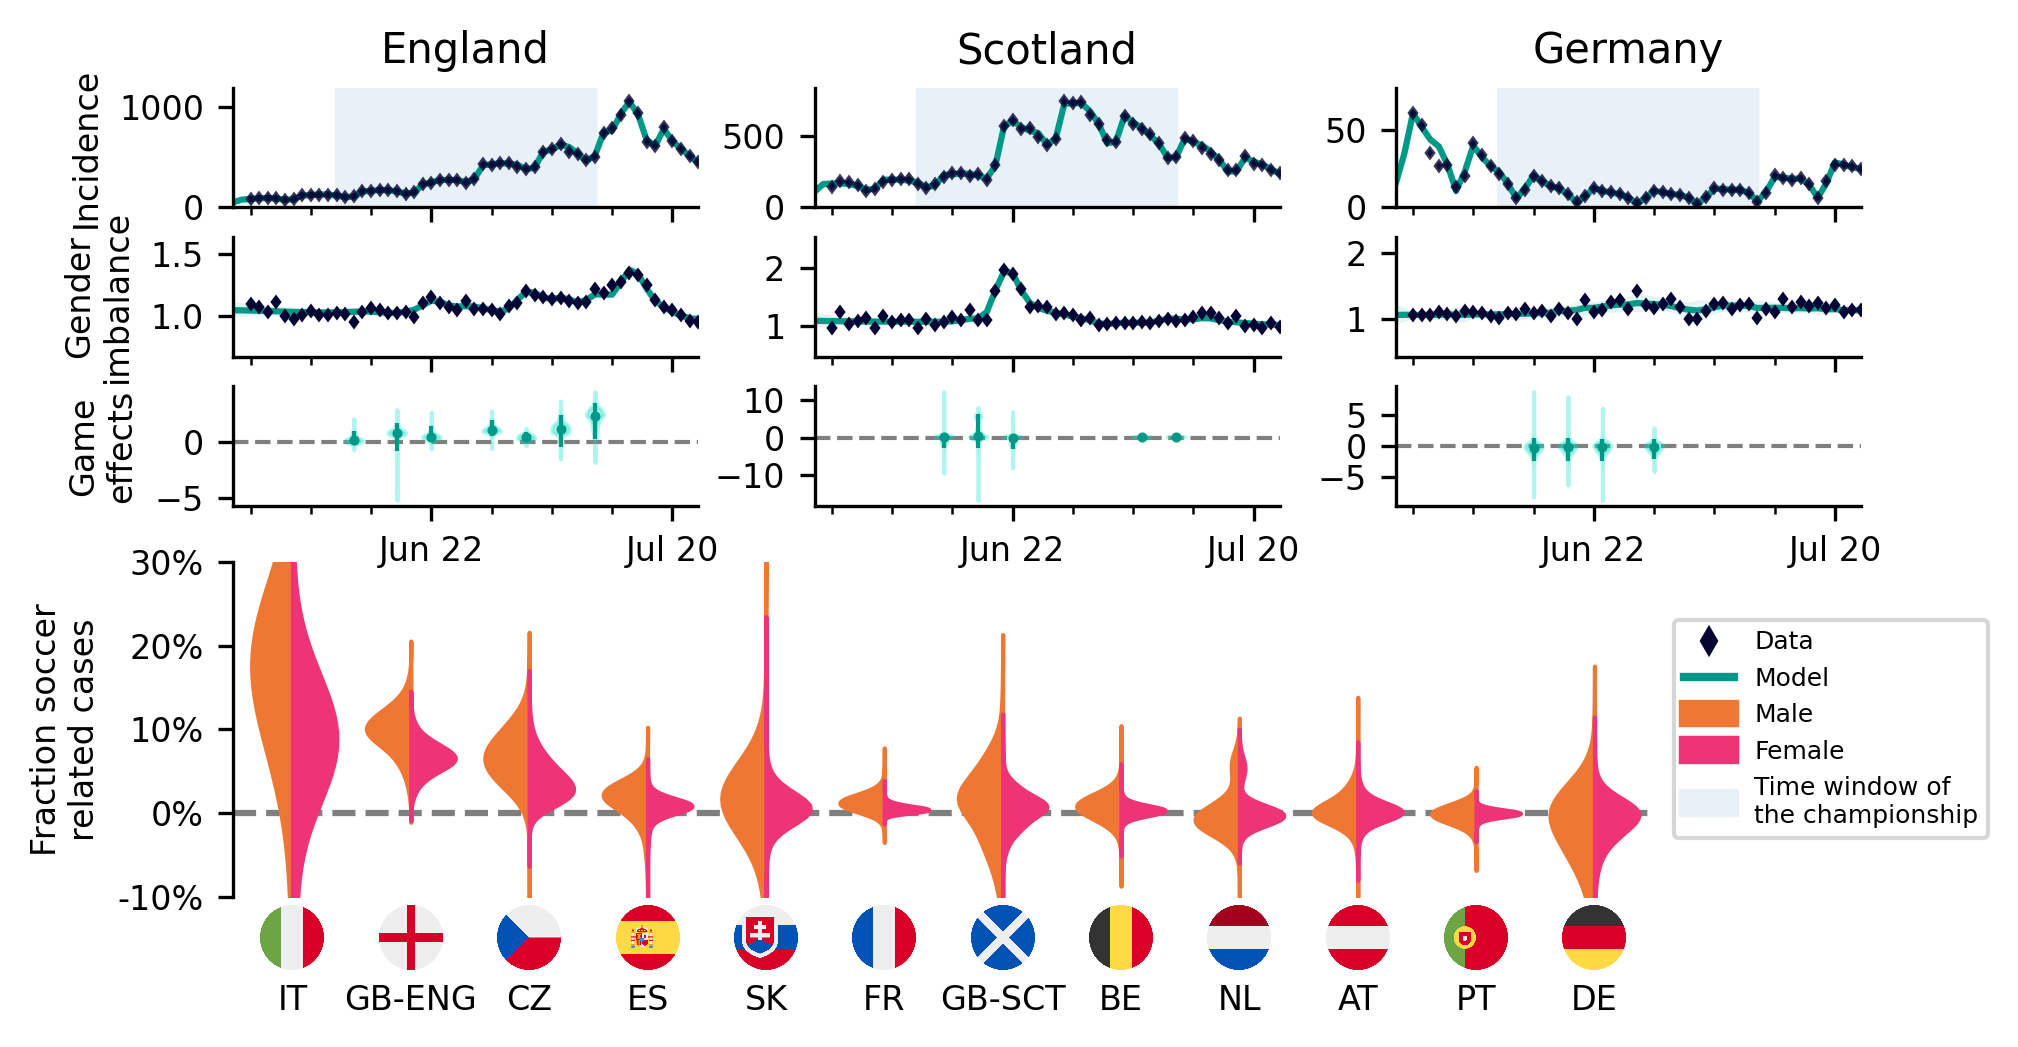

In [10]:
fig = plt.figure(figsize=(7, 3.5))
axes = covid19_soccer.plot.overview.multi_v2(traces,models,dls,xlim=xlim_ts, selected_index=[0,1,2], nColumns=3, fig=fig, ypos_flags=-10)
axes[-1][0].set_ylim(-10,30)
axes[-1][0].set_ylabel("Fraction soccer\nrelated cases")
axes[-1][0].set_facecolor('none')
fig.savefig(f"{fig_path}/overview_infections.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/overview_infections.png", **save_kwargs)
plt.show()
plt.close(fig=fig)

/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:697: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=2.5,),)
/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:701: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=2.5,),)


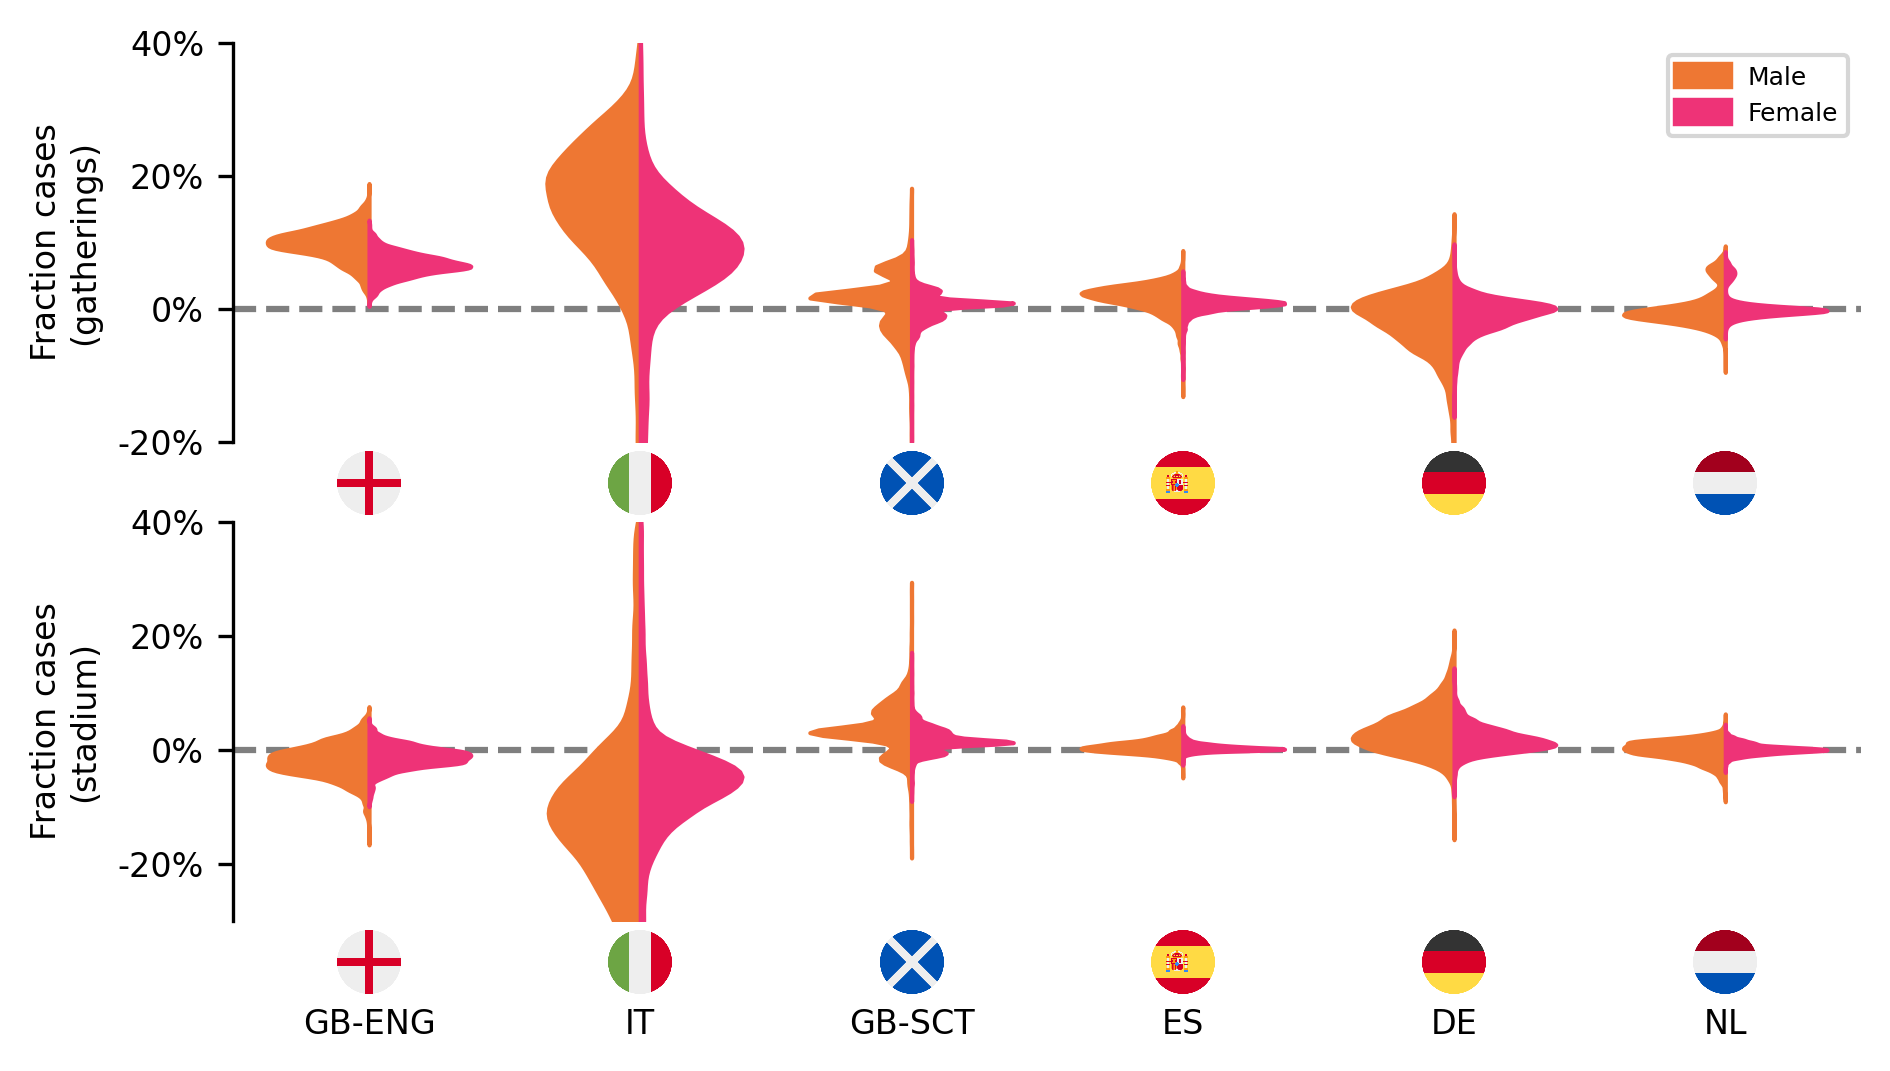

In [7]:
fig, axes = plt.subplots(2,1,figsize=(7, 3.8))


selection = np.array([0,1,2,4,7,8])

traces_selected = [t for i,t in enumerate(traces) if i in selection]
models_selected = [m for i,m in enumerate(models) if i in selection]
dls_selected = [dl for i,dl in enumerate(dls) if i in selection]
covid19_soccer.plot.other.soccer_related_cases_overview(
    ax=axes[0],
    traces=traces_selected,
    models=models_selected,
    dls=dls_selected,
    plot_flags=True,
    ypos_flags=-20,
    plot_betas=False,
    country_order=[0,5,1,3,2,4],
    remove_outliers=True
)
covid19_soccer.plot.other.soccer_related_cases_overview(
    ax=axes[1],
    traces=traces_selected,
    models=models_selected,
    dls=dls_selected,
    plot_flags=True,
    ypos_flags=-30,
    plot_betas=True,
    country_order=[0,5,1,3,2,4],
    remove_outliers=True
)

axes[0].set_ylim(-20,40)
axes[0].set_ylabel("Fraction cases\n(gatherings)")
axes[0].set_xticklabels([])
axes[1].set_ylim(-30,40)
axes[1].set_ylabel("Fraction cases\n(stadium)")

covid19_soccer.plot.other.legend(ax=axes[0],data=False,posterior=False,prior=False,model=False,disable_axis=False,loc=1)
plt.show()
fig.savefig(f"{fig_path}/validation/beta.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/validation/beta.png", **save_kwargs)
plt.close(fig=fig)

## Main figure with -14 days data offset

In [56]:
# Load data
countries = ["England","Scotland","Germany","France","Spain","Slovakia","Portugal","Netherlands","Italy","Czechia","Belgium","Austria"]
traces, models, dls = [], [], []
offset_data = -14
for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data={offset_data}"+
        f"-draw_delay=True"+
        f"-weighted_alpha_prior=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+                
        f"-tune={tune}"+
        f"-draws={draws}"+
        f"-max_treedepth={max_treedepth}.pickled")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(500, 1000, 12)):
        try:
            model, trace = load(fstr(500, 1000, 12))
            print(f"Use 1000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(200, 300, 10)):
        try:
            model, trace = load(fstr(200, 300, 10))
            print(f"Use 300 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_data=offset_data,old_timetable=True)

    models.append(model)
    traces.append(trace)
    dls.append(dl)


  0%|          | 0/12 [00:00<?, ?it/s]

Use 1000 sample runs for England
Use 1000 sample runs for Scotland
Use 1000 sample runs for Germany
Use 1000 sample runs for France
Use 1000 sample runs for Spain
Use 1000 sample runs for Slovakia
Use 1000 sample runs for Portugal
Use 1000 sample runs for Netherlands
Use 1000 sample runs for Italy
Use 1000 sample runs for Czechia
Use 1000 sample runs for Belgium
Use 1000 sample runs for Austria


In [45]:
for model in models:
    dl._data_begin = model._data_begin + datetime.timedelta(days=offset_data)
    model._data_end = model._data_end + datetime.timedelta(days=offset_data)
    model._sim_begin = model._sim_begin + datetime.timedelta(days=offset_data)
    model._sim_end = model._sim_end + datetime.timedelta(days=offset_data)
    

/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:786: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(
/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:797: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(


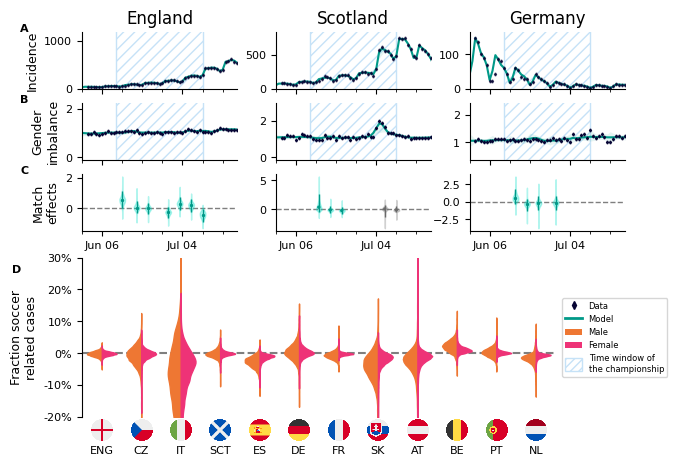

In [57]:
fig = plt.figure(figsize=(7, 5))

country_order = [0,9,8,1,4,2,3,5,11,10,6,7]

axes = covid19_soccer.plot.overview.multi_v2(
    traces=traces,
    models=models,
    dls=dls,
    xlim=xlim_ts,
    selected_index=[0,1,2],
    nColumns=3,
    fig=fig,
    ypos_flags=-20,
    country_order=country_order,
)
axes[-1][0].set_ylim(-20,30)
axes[-1][0].set_ylabel("Fraction soccer\nrelated cases")
axes[-1][0].set_facecolor('none')

# Add label letters to figure
letters = np.array(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
text_kwargs = {
    "x":-0.40,
    "y":1.15,
    "fontsize":8,
    "fontweight":"bold",
    "verticalalignment":"top"
}
axes[0][0].text(
    s=letters[0],
    transform=axes[0][0].transAxes,
    **text_kwargs
)
axes[0][1].text(
    s=letters[1],
    transform=axes[0][1].transAxes,
    **text_kwargs
)
axes[0][2].text(
    s=letters[2],
    transform=axes[0][2].transAxes,
    **text_kwargs
)
axes[3][0].text(
    s=letters[3],
    transform=axes[0][2].transAxes,
    x=text_kwargs["x"]-0.05,
    y=-0.6,
    fontsize=8,
    fontweight="bold",
    verticalalignment="top"
)

fig.savefig(f"{fig_path}/overview_infections_offset_-14.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/overview_infections_offset_-14.png", **save_kwargs)

plt.show()
plt.close(fig=fig)